# Methodology of model assessment and selection

To compare two or more models i will use auc as a metric. To estimate this quantity with confidence i use k-fold cross validation: 

The data set is split with a ratio of 80 to 20 into a training and a test set. The test will be untouched until the very and of the analysis. The training set then is used for the crossvalidation loop. 

I implemented this with the help of the *caret* package in the *helpers* script. Note that the *helpers* script loads *tidyverse* and *caret* implicit.


In [1]:
source("helpers.r")
df <- get_training_df()
glimpse(df)

Warning message:
"package 'tidyverse' was built under R version 3.6.1"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'caret' was built under R version 3.6.1"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_doubl

Observations: 243
Variables: 14
$ age      <dbl> 63, 37, 41, 56, 57, 56, 44, 52, 57, 54, 48, 49, 64, 58, 50...
$ thalach  <dbl> 150, 187, 172, 178, 163, 153, 173, 162, 174, 160, 139, 171...
$ trestbps <dbl> 145, 130, 130, 120, 120, 140, 120, 172, 150, 140, 130, 130...
$ oldpeak  <dbl> 2.3, 3.5, 1.4, 0.8, 0.6, 1.3, 0.0, 0.5, 1.6, 1.2, 0.2, 0.6...
$ ca       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
$ chol     <dbl> 233, 250, 204, 236, 354, 294, 263, 199, 168, 239, 275, 266...
$ restecg  <fct> normal, ST-T_abnormalty, normal, ST-T_abnormalty, ST-T_abn...
$ fbs      <fct> yes, no, no, no, no, no, no, yes, no, no, no, no, no, yes,...
$ sex      <fct> Male, Male, Female, Male, Female, Female, Male, Male, Male...
$ exang    <fct> no, no, no, no, yes, no, no, no, no, no, no, no, yes, no, ...
$ cp       <fct> asymptomatic, non-anginal_pain, atypical_angina, atypical_...
$ slope    <fct> upsloping, upsloping, downsloping, downsloping, downslopin...
$ target   <fct> dis

The k-fold cross validation is now set up with $k = 10$. A tibble that stores the results is also prepared.

In [2]:
library(MLmetrics)
library(magrittr)

set.seed(25)
number_of_folds <- 10
folds <- createFolds(df$target, k = number_of_folds)
model_result <- tibble(model = vector("character"),
                       auc = vector("numeric"))

for(fold_index in c(1:number_of_folds)){
    training <- df[-folds[[fold_index]],]
    test <- df[folds[[fold_index]],]
    
    y_true <- ifelse(test$target == "no_disease", 0, 1)
    
    fit <- glm(target ~ ., data=training, family =binomial(link = "logit"))
    y_probabilities <- unname(predict(fit, test,  type="response"))

    auc <- AUC(y_true = y_true, y_pred = y_probabilities)
    
    model_result %<>%
      add_row(model = "logistic regression", auc = auc)
 
  }

model_result %>%
    group_by(model) %>%
    summarize(mean = mean(auc),
              median = median(auc),
              sd = sd(auc))
                 

Warning message:
"package 'MLmetrics' was built under R version 3.6.1"
Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:base':

    Recall


Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract



model,mean,median,sd
logistic regression,0.8936314,0.8921079,0.06699914


Note that i already created the tibble that is used to store the result with a column for different models. Now let's extend the cross validation loop to compare two different models:

In [3]:
library(rpart)
model_result <- tibble(model = vector("character"),
                       auc = vector("numeric"))
models <- c("logistic regression", "decision tree")

for(model in models){
    for(fold_index in c(1:number_of_folds)){
        training <- df[-folds[[fold_index]],]
        test <- df[folds[[fold_index]],]

        y_true <- ifelse(test$target == "no_disease", 0, 1)

        if (model == "logistic regression") {
          fit <- glm(target ~., data=training, family =binomial(link = "logit"))
          y_probabilities <- unname(predict(fit, test,  type="response"))
        }
        if (model == "decision tree"){
          fit <- rpart(target ~., data=training, method = "class")
          y_probabilities <- unname(predict(fit, test)[,2])
        }

        auc <- AUC(y_true = y_true, y_pred = y_probabilities)

        model_result %<>%
          add_row(model = model, auc = auc)

      }
}

model_result %>%
    group_by(model) %>%
    summarize(mean = mean(auc),
              median = median(auc),
              sd = sd(auc))

model,mean,median,sd
decision tree,0.8191850,0.8198052,0.06599059
logistic regression,0.8936314,0.8921079,0.06699914


We can also visual inspect, that the logistic regression performs probably better than the decision tree:

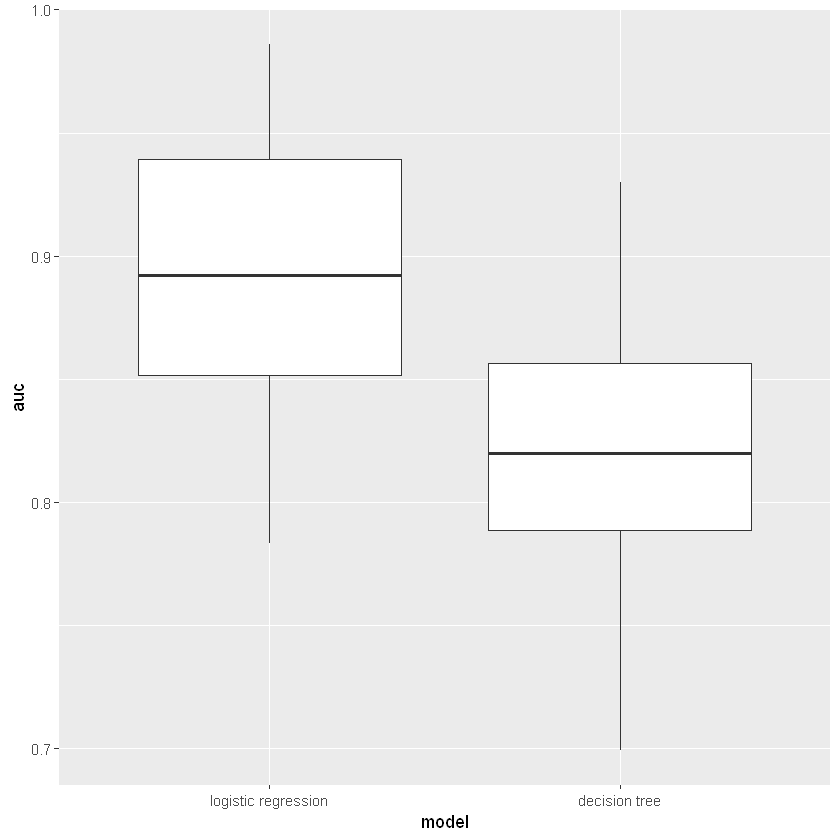

In [4]:
model_result %>%
    mutate(model = factor(model, levels = models)) %>%
    ggplot(aes(x = model, y = auc))+
    geom_boxplot()

To really compare the models a t-test is probably useful:

In [5]:
auc_log_reg <- model_result %>%
  filter(model == "logistic regression")
auc_log_reg <- auc_log_reg[, "auc", drop = TRUE]
auc_tree <- model_result %>%
  filter(model == "decision tree")
auc_tree <- auc_tree[, "auc",  drop = TRUE]

t.test(auc_log_reg, auc_tree, paired = TRUE, alternative = "two.sided")


	Paired t-test

data:  auc_log_reg and auc_tree
t = 4.1435, df = 9, p-value = 0.002508
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.0338026 0.1150902
sample estimates:
mean of the differences 
             0.07444639 


Provided that the assumption of the test setting were fulfilled, the difference of the means is significant and hence the logistic regression has a better performance. 

In the paper *"Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithm"* from Thomas Dietterich, 1997 the high probability of a Type I error of this test is shown. This is because the test and training sets are not really indepentently drawn. 

The loop for the crossvalidation builds the baseline for my analysis and is will be extended through the process. 